In [1]:
from pathlib import Path
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import json

from hydrosystem.discharge.nam import NAMParameters

path_to_data = Path("../src/data/processed")

from hydrosystem.discharge import nam
from hydrosystem.discharge.nam.observation import NAMTarget
from hydrosystem.discharge.nam.step import step, step_excel

from matplotlib import pyplot as plt

C:\Users\MUNRAS\PycharmProjects\NAM\.venv\Lib\site-packages\jax\_src\numpy\array_methods.py:125: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [2]:
timeseries = pd.read_csv(path_to_data/ "timeseries_corrected.csv")
timeseries_train = timeseries[
    np.logical_and.reduce((
        pd.to_datetime(timeseries["date"]).dt.year >= 1971, # Not part of reference period
        pd.to_datetime(timeseries["date"]).dt.year <= 1990, # Not part of reference period
    ))
]
timeseries_validation = timeseries[
    np.logical_and.reduce((
        pd.to_datetime(timeseries["date"]).dt.year >= 1991, # Not part of reference period
        pd.to_datetime(timeseries["date"]).dt.year <= 2000, # Not part of reference period
    ))
]
observations_train = nam.NAMObservation(
    p=jnp.asarray(timeseries_train["p"]),
    t=jnp.asarray(timeseries_train["t"]),
    epot=jnp.asarray(timeseries_train["epot"])
)
target_train = NAMTarget.from_partial(timeseries_train["q"])
observations_validation = nam.NAMObservation(
    p=jnp.asarray(timeseries_validation["p"]),
    t=jnp.asarray(timeseries_validation["t"]),
    epot=jnp.asarray(timeseries_validation["epot"])
)
target_validation = NAMTarget.from_partial(timeseries_validation["q"])

alpha_fake = jnp.asarray([0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
weights_thresholds = jnp.concat([jnp.array([-999]), jnp.quantile(target_train.q, jnp.asarray([0.5, 0.6, 0.7, 0.8, 0.9, 0.95]))])
weights_train = [
    jax.tree.map(lambda x: x>tr, target_train)
    for tr in weights_thresholds
]
weights_validation = [
    jax.tree.map(lambda x: x>tr, target_validation)
    for tr in weights_thresholds
]
weights_validation_matrix = jnp.stack([w.q for w in weights_validation], axis=-1) # (n,k)

In [52]:
def get_pred(alpha):
    q_alpha = jnp.quantile(target_train.q, alpha)
    w_alpha_train = jax.tree.map(lambda x: x > q_alpha, target_train)

    optimized_params, optimizer_trace = nam.optimize_cma_es(
        initial_params, observations_train, target_train, weights=w_alpha_train, abssum_weight=1e-6,
        n_population=256, n_generations=128
    )
    optimized_params_val, _ = nam.predict(optimized_params, observations_train)
    _, pred_val = nam.predict(optimized_params_val, observations_validation)
    return pred_val

def evaluate(pred_val, alpha, beta):
    q_alpha = jnp.quantile(target_train.q, alpha)
    w_alpha_train = jax.tree.map(lambda x: x > q_alpha, target_train)
    q_beta = jnp.quantile(target_validation.q, beta)
    w_beta_val = jax.tree.map(lambda x: x > q_beta, target_validation)
    mse_val = jnp.mean(jnp.square(pred_val.q - target_validation.q) * w_beta_val.q)

    #wmean = jnp.sum(target_train.q * w_alpha_train.q) / jnp.sum(w_alpha_train.q)
    #mse_val_baseline = jnp.mean(jnp.square(wmean - target_validation.q) * w_beta_val.q)

    return mse_val#(mse_val_baseline-mse_val) / mse_val_baseline


In [53]:
records = []
for alpha in alpha_fake:
    pred = get_pred(alpha)
    for beta in alpha_fake:
        records.append({
            "alpha": float(alpha),
            "beta": float(beta),
            "mse": float(evaluate(pred, alpha, beta))
        })
res_df = pd.DataFrame.from_records(records)

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

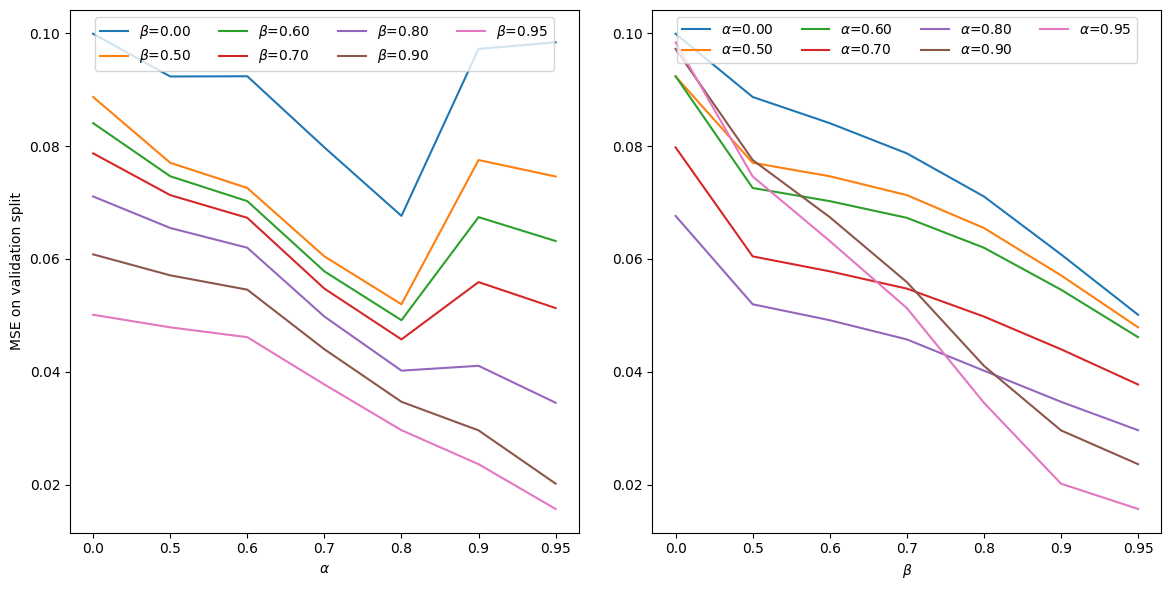

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=False)

ax = axs[0]
for beta in alpha_fake:
    series = res_df[res_df["beta"] == beta]
    ax.plot([str(round(x,2)) for x in series["alpha"]], series["mse"], label=f"$\\beta$={beta:.2f}")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE on validation split")
ax.legend(loc="upper center", ncols=4)

ax = axs[1]
for alpha in alpha_fake:
    series = res_df[res_df["alpha"] == alpha]
    ax.plot([str(round(x,2)) for x in series["beta"]], series["mse"], label=f"$\\alpha$={alpha:.2f}")
ax.set_xlabel("$\\beta$")
ax.legend(loc="upper center", ncols=4)

fig.tight_layout()

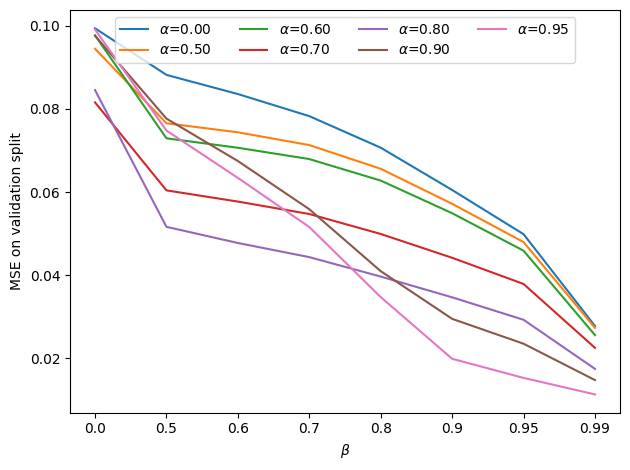

In [270]:
fig, ax = plt.subplots()
for alpha in alpha_fake:
    series = res_df[res_df["alpha"] == alpha]
    ax.plot([str(round(x,2)) for x in series["beta"]], series["mse"], label=f"$\\alpha$={alpha:.2f}")
ax.set_xlabel("$\\beta$")
ax.set_ylabel("MSE on validation split")
ax.legend(loc="upper center", ncols=4)
fig.savefig("plots/weights_experiment.png")
fig.tight_layout()

In [5]:
baseline_mse = jnp.mean(jnp.square(jnp.mean(target_train.q) - target_train.q))
baseline_mse_val = jnp.mean(jnp.square(jnp.mean(target_train.q) - target_validation.q))

In [6]:
initial_params = nam.NAMParameters.from_physical()
initial_params_final, qsim_initial_params = nam.predict(initial_params, observations_train)
_, qsim_initial_params_val = nam.predict(initial_params_final, observations_validation)
initial_params_mse = jnp.mean(jnp.square(qsim_initial_params.q - target_train.q))
initial_params_mse_val = jnp.mean(jnp.square(qsim_initial_params_val.q - target_validation.q))
initial_params_r2 = (baseline_mse - initial_params_mse) / baseline_mse
initial_params_r2_val = (baseline_mse_val - initial_params_mse_val) / baseline_mse_val

In [61]:
optimized_params, optimizer_trace = nam.optimize_cma_es(
    initial_params, observations_train, target_train, weights=weights_train[-3], abssum_weight=0,
    n_population=256, n_generations=128
)
with open("optimized_params.json", "w") as f:
    json.dump({k:float(x) for k,x in optimized_params._asdict().items()}, f)

Optimizing...:   0%|          | 0/128 [00:00<?, ?it/s]

In [63]:
optimized_params

NAMParameters(area_=Array(1055., dtype=float32), c_area_=Array(0.37816453, dtype=float32), cqof_=Array(-2.3087137, dtype=float32), ckif_=Array(-2.2207258, dtype=float32), tof_=Array(-72.99702, dtype=float32), tif_=Array(-18.771038, dtype=float32), tg_=Array(-120.29925, dtype=float32), ck1_=Array(1.331665, dtype=float32), ck2_=Array(-13.81551, dtype=float32), ckbf_=Array(5.813512, dtype=float32), c_snow_=Array(1.8545866, dtype=float32), u_max_=Array(-30.446444, dtype=float32), l_max_=Array(91.53121, dtype=float32), s_=Array(-13.81551, dtype=float32), u_ratio_=Array(3.8059235, dtype=float32), l_ratio_=Array(33.692078, dtype=float32), qr1_=Array(104.99313, dtype=float32), qr2_=Array(-13.81551, dtype=float32), bf_=Array(0.7167511, dtype=float32))

In [71]:
from hydrosystem.discharge.nam.parameters import NAMParameters
pdict = optimized_params._asdict()
# pdict["u_ratio_"] = 0.
# pdict["l_ratio_"] = 0.
pdict["qr1_"] = pdict["qr1_"] * 0
opt_par_chill_start = NAMParameters(**pdict)

In [72]:
opt_par_val, pred_train = nam.predict(opt_par_chill_start, observations_train)
_, pred_val = nam.predict(opt_par_val, observations_validation)
mse = jnp.mean(jnp.square(pred_val.q - target_validation.q))
(baseline_mse_val - mse) / baseline_mse_val

Array(0.7837479, dtype=float32)

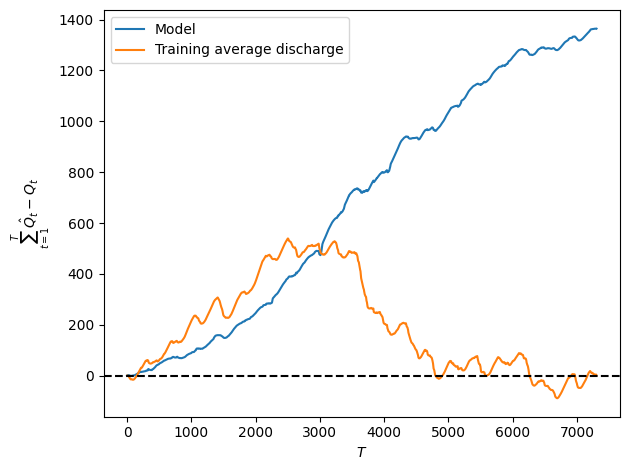

In [73]:
fig, ax = plt.subplots()
ax.plot(jnp.cumsum(pred_train.q - target_train.q), label="Model")
ax.plot(jnp.cumsum(jnp.mean(target_train.q) - target_train.q), label="Training average discharge")
ax.axhline(y=0, linestyle="--", color="k")
ax.set_xlabel("$T$")
ax.set_ylabel("$\\sum_{t=1}^T \\hat{Q}_t - Q_t$")
ax.legend()
fig.tight_layout()
#fig.savefig("plots/cumulative_bias_train.png")

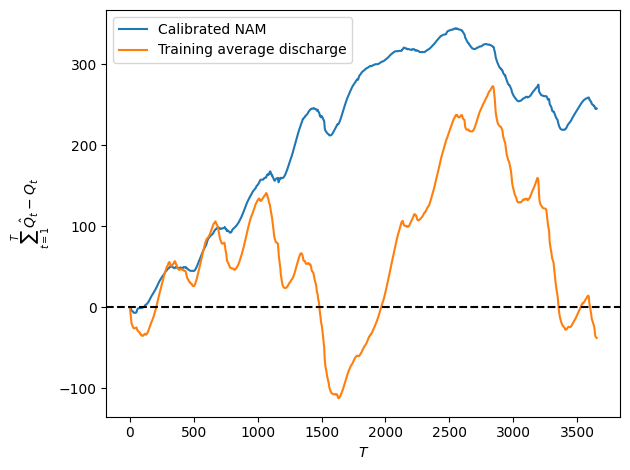

In [59]:
fig, ax = plt.subplots()
ax.plot(jnp.cumsum(pred_val.q - target_validation.q), label="Calibrated NAM")
ax.plot(jnp.cumsum(jnp.mean(target_train.q) - target_validation.q), label="Training average discharge")
ax.axhline(y=0, linestyle="--", color="k")
ax.set_xlabel("$T$")
ax.set_ylabel("$\\sum_{t=1}^T \\hat{Q}_t - Q_t$")
ax.legend()
fig.tight_layout()
fig.savefig("plots/cumulative_bias_validation.png")

In [8]:
optimized_params_final, qsim_optimized_params = nam.predict(optimized_params, observations_train)
_, qsim_optimized_params_val = nam.predict(optimized_params_final, observations_validation)
optimized_params_mse = jnp.mean(jnp.square(qsim_optimized_params.q - target_train.q))
optimized_params_mse_val = jnp.mean(jnp.square(qsim_optimized_params_val.q - target_validation.q))
optimized_params_r2 = (baseline_mse - optimized_params_mse) / baseline_mse
optimized_params_r2_val = (baseline_mse_val - optimized_params_mse_val) / baseline_mse_val

In [9]:
initial_params_r2, optimized_params_r2, initial_params_r2_val, optimized_params_r2_val

(Array(-0.17249219, dtype=float32),
 Array(0.7698518, dtype=float32),
 Array(0.31733456, dtype=float32),
 Array(0.7430132, dtype=float32))

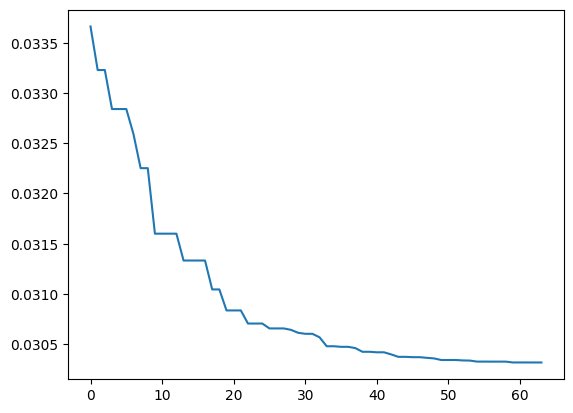

In [45]:
plt.plot([x["best_fitness"] for x in optimizer_trace])

In [ ]:
# TODO - Calculate predictions

In [ ]:
# TODO - Write some plotting code and explain the optimization procedure in report